# Init

In [9]:
using Mocha
using Distributions
using Plots; pyplot()
using JLD
#include("/home/gkraemer/progs/IndexExplorer/src/nlPCANet.jl");

# Parameters

In [10]:
σ = 0.05                       # standard deviation of noise
t = linspace(-1,1,1000);       # number and range of samples

# nlpca parameters general parameters
structure = Integer[1,8]
NAvalue   = NaN
backend   = CPUBackend()
#neurons   = ActivationFunction[ Neurons.Tanh() for i in 1:length(structure) ]
neurons = ActivationFunction[ Neurons.Identity(), Neurons.Tanh()]



# solver parameters
iterations    = 80000
learning_rate = 0.03
momentum      = 0.04
method        = SGD();#Adam()
base_dir      = "nlpca_helix_snapshots";



# Data Generation

In [11]:
data = Array(Float64, (3,length(t)))
data[1,:] = sin(π*t) + rand(Normal(0,σ), length(t))
data[2,:] = cos(π*t) + rand(Normal(0,σ), length(t))
data[3,:] = t        + rand(Normal(0,σ), length(t))
data_full = deepcopy(data)
for i in 1:length(t)
    data[rand(1:3),i] = NaN
end


# nlPCA

In [ ]:
registry_reset(backend)
rm(base_dir, recursive = true)

# parameters for the net 
n_layers = length(structure)
n_samples = size(data,2)
n_dims    = size(data,1)
batch_size = n_samples

# define layers 
data_layer = Mocha.MemoryDataLayer( name = "data",
                                    tops = [:data],
                                    data = Array[data],
                                    batch_size = batch_size )

eye_input = eye(eltype(data),n_samples)
eye_layer = Mocha.MemoryDataLayer( name = "eye",
                                   tops = [:eye],
                                   data = Array[eye_input],
                                   batch_size = batch_size )

inner_layers = [ Mocha.InnerProductLayer( name       = "ip-$i",
                                          #weight_init = Mocha.GaussianInitializer(0,1),
                                          #bias_init = Mocha.GaussianInitializer(0,1),
                                          #bias_lr = 0.5,
                                          output_dim = structure[i],
                                          neuron     = neurons[i],
                                          bottoms    = i == 1 ? [:eye] : [symbol("ip$(i-1)")],
                                          tops       = [symbol("ip$i")] )
                 for i in 1:n_layers ]

last_inner_layer = Mocha.InnerProductLayer( name       = "ip-last",
                                            #weight_init = Mocha.GaussianInitializer(0,1),
                                            #bias_init = Mocha.GaussianInitializer(0,1),
                                            #bias_lr = 0.5,
                                            output_dim = n_dims,
                                            neuron     = Mocha.Neurons.Identity(),
                                            bottoms    = [symbol("ip$n_layers")],
                                            tops       = [:ip_last] )

loss_layer = Mocha.NaSquareLossLayer( name    = "loss",
                                      NAvalue = NAvalue,
                                      bottoms = [:ip_last, :data])


layers = [ eye_layer,
           inner_layers...,
           last_inner_layer,
           loss_layer,
           data_layer ]

nlpcanet = Mocha.Net( "nlPCANet", backend, layers )


isdir(base_dir) || mkdir(base_dir)

open("$base_dir/net.dot", "w") do out
    Mocha.net2dot(out, nlpcanet)
end
run(pipeline(`dot -Tpng $base_dir/net.dot`, "$base_dir/net.png"))
println("Network topology saved to $base_dir/net.dot")

<img src="nlpca_helix_snapshots/net.png" />

In [12]:
solver_params = make_solver_parameters( method, 
                                        max_iter = iterations, 
                                        regu_coef = 0.0, 
                                        mom_policy = MomPolicy.Fixed(momentum),
                                        lr_policy = LRPolicy.Fixed(learning_rate),
                                        load_from = base_dir ) 
solver = Solver(method, solver_params)
setup_coffee_lounge( solver, save_into = "$base_dir/statistics.jld", every_n_iter = 1000)
add_coffee_break( solver, TrainingSummary(),  every_n_iter = 1000)
add_coffee_break( solver, Snapshot(base_dir), every_n_iter = 1000)

solve( solver, nlpcanet )
@async run(`espeak beep`)

11-Jan 15:05:16:INFO:root:Constructing net nlPCANet on Mocha.CPUBackend...
11-Jan 15:05:16:INFO:root:Topological sorting 6 layers...
11-Jan 15:05:16:INFO:root:Setup layers...
11-Jan 15:05:16:INFO:root:Network constructed!
Network topology saved to nlpca_helix_snapshots/net.dot
11-Jan 15:05:18:DEBUG:root:#DEBUG Checking network topology for back-propagation
11-Jan 15:05:18:DEBUG:root:Init network nlPCANet
11-Jan 15:05:18:DEBUG:root:Init parameter weight for layer ip-1
11-Jan 15:05:18:DEBUG:root:Init parameter bias for layer ip-1
11-Jan 15:05:18:DEBUG:root:Init parameter weight for layer ip-2
11-Jan 15:05:18:DEBUG:root:Init parameter bias for layer ip-2
11-Jan 15:05:18:DEBUG:root:Init parameter weight for layer ip-last
11-Jan 15:05:18:DEBUG:root:Init parameter bias for layer ip-last
11-Jan 15:05:18:DEBUG:root:#DEBUG Initializing coffee breaks


11-Jan 15:05:18:INFO:root:Snapshot directory nlpca_helix_snapshots already exists
11-Jan 15:05:19:INFO:root: TRAIN iter=000000 obj_val=0.45160241
11-Jan 15:05:19:INFO:root:Saving snapshot to snapshot-000000.jld...
11-Jan 15:05:19:DEBUG:root:Saving parameters for layer ip-1
11-Jan 15:05:19:DEBUG:root:Saving parameters for layer ip-2
11-Jan 15:05:19:DEBUG:root:Saving parameters for layer ip-last
11-Jan 15:05:21:DEBUG:root:#DEBUG Entering solver loop
11-Jan 15:05:31:INFO:root: TRAIN iter=001000 obj_val=0.41940806


11-Jan 15:05:31:INFO:root:Saving snapshot to snapshot-001000.jld...
11-Jan 15:05:31:DEBUG:root:Saving parameters for layer ip-1
11-Jan 15:05:31:DEBUG:root:Saving parameters for layer ip-2
11-Jan 15:05:31:DEBUG:root:Saving parameters for layer ip-last
11-Jan 15:05:40:INFO:root: TRAIN iter=002000 obj_val=0.43111781
11-Jan 15:05:40:INFO:root:Saving snapshot to snapshot-002000.jld...
11-Jan 15:05:40:DEBUG:root:Saving parameters for layer ip-1
11-Jan 15:05:40:DEBUG:root:Saving parameters for layer ip-2
11-Jan 15:05:40:DEBUG:root:Saving parameters for layer ip-last
11-Jan 15:05:50:INFO:root: TRAIN iter=003000 obj_val=0.26420864
11-Jan 15:05:50:INFO:root:Saving snapshot to snapshot-003000.jld...
11-Jan 15:05:50:DEBUG:root:Saving parameters for layer ip-1
11-Jan 15:05:50:DEBUG:root:Saving parameters for layer ip-2
11-Jan 15:05:50:DEBUG:root:Saving parameters for layer ip-last
11-Jan 15:05:59:INFO:root: TRAIN iter=004000 obj_val=0.22762845
11-Jan 15:05:59:INFO:root:Saving snapshot to snapshot-0

Task (waiting) @0x00007f5a6dc90e20

In [18]:
mem_out_layer = Mocha.MemoryOutputLayer( name = "prediction",
                                         bottoms = [:ip1,:ip_last, :eye] )

ae_pred = Mocha.Net( "predict", nlpcanet.backend, [ nlpcanet.layers..., mem_out_layer ] )
Mocha.load_snapshot(ae_pred, base_dir)
forward_epoch(ae_pred)
data_predicted = hcat(Mocha.get_layer_state(ae_pred, "prediction").outputs[2]...)
nlpca_axis     = hcat(Mocha.get_layer_state(ae_pred, "prediction").outputs[1]...);


11-Jan 15:19:01:INFO:root:Constructing net predict on Mocha.CPUBackend...
11-Jan 15:19:01:INFO:root:Topological sorting 7 layers...
11-Jan 15:19:01:INFO:root:Setup layers...
11-Jan 15:19:01:DEBUG:root:InnerProductLayer(ip-1): sharing weights and bias
11-Jan 15:19:01:DEBUG:root:InnerProductLayer(ip-2): sharing weights and bias
11-Jan 15:19:01:DEBUG:root:InnerProductLayer(ip-last): sharing weights and bias
11-Jan 15:19:01:INFO:root:Network constructed!
11-Jan 15:19:01:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-080000.jld
11-Jan 15:19:01:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:19:01:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:19:01:DEBUG:root:Loading parameters for layer ip-last


1x1000 Array{Float64,2}:
 0.487005  0.524772  0.466233  0.514682  …  -0.539683  -0.525055  -0.0437331

# Plots

[Plots.jl] Initializing backend: pyplot

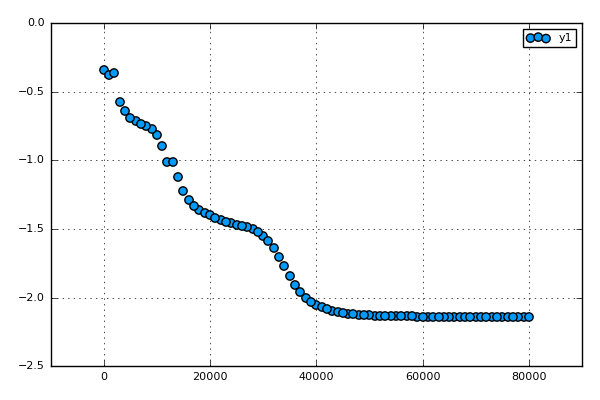

In [20]:
stats = load("nlpca_helix_snapshots/statistics.jld")["statistics"]
x = collect(keys(stats["obj_val"]))
y = Float64[ stats["obj_val"][xx] for xx in x ]
Plots.scatter(x, log10(y) )

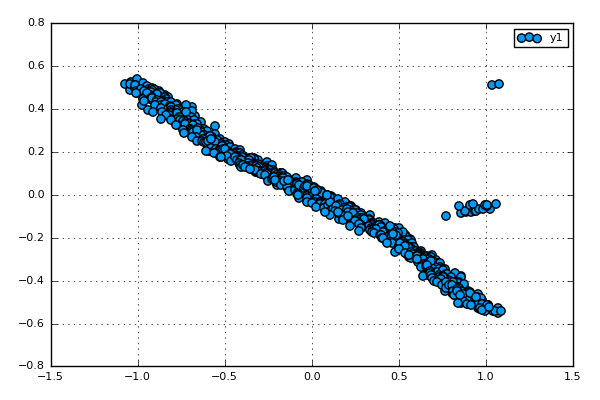

In [22]:
Plots.scatter(squeeze(data_full[3,:],1),
              squeeze(nlpca_axis[1,:],1))

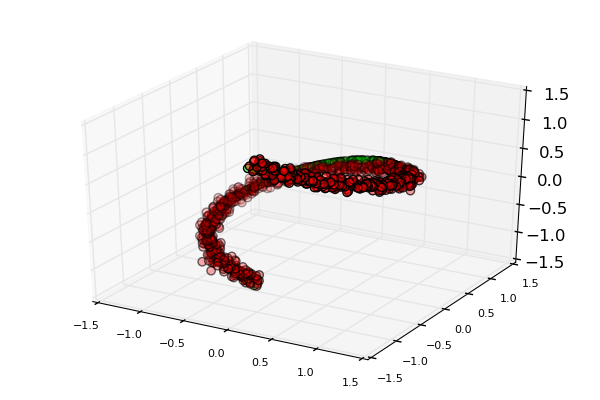

In [24]:
scatter3d( squeeze(data_full[1,:],1), 
           squeeze(data_full[2,:],1), 
           squeeze(data_full[3,:],1),
           c = RGBA(1,0,0,.5))
scatter3d!( squeeze(data_predicted[1,:],1), 
            squeeze(data_predicted[2,:],1), 
            squeeze(data_predicted[3,:],1), 
            c = RGBA(0,1,0,.5))

In [28]:
files = readdir(base_dir)
files = files[ Bool[ ismatch(r"0\.jld$",x) for x in files ] ]
p = Plot.scatter3d()
anim = Animation()

for f in files
    println(f)
    reset_outputs(get_layer_state(ae_pred,"prediction"))
    load_snapshot(ae_pred, "$base_dir/$f")
    forward_epoch(ae_pred)
    data_predicted = hcat(get_layer_state(ae_pred, "prediction").outputs[2]...)
    #=
    Plots.scatter3d( squeeze(data_predicted[1,:],1), 
                     squeeze(data_predicted[2,:],1), 
                     squeeze(data_predicted[3,:],1), 
                     c = RGBA(0,1,0,.5))
    anim = Animation(current(), anim.dir, anim.frames)
    =#
    frame(anim)
end
gif(anim, "$base_dir/animation.gif", fps = 40)
@async run(`espeak beep`)

snapshot-000000.jld
11-Jan 15:29:16:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-000000.jld
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snapshot-001000.jld
11-Jan 15:29:16:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-001000.jld
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snapshot-002000.jld
11-Jan 15:29:16:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-002000.jld
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:16:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snap

/home/gkraemer/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


11-Jan 15:29:17:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-008000.jld
11-Jan 15:29:17:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:17:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:17:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snapshot-009000.jld
11-Jan 15:29:18:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-009000.jld
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snapshot-010000.jld
11-Jan 15:29:18:INFO:root:Loading existing model from nlpca_helix_snapshots/snapshot-010000.jld
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-1
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-2
11-Jan 15:29:18:DEBUG:root:Loading parameters for layer ip-last
size(data_predicted,2) = 1000
snapshot-011000.jld
11-J

Task (waiting) @0x00007f5a6a5f0fb0

<img src="nlpca_helix_snapshots/animation.gif" />

In [73]:
using PyPlot
pygui(true)

data_error_partial_sq = (data_predicted .- data_full).^2

data_error = sum(data_error_partial_sq,1)

scatter3D(squeeze(data_predicted[1,:],1), 
          squeeze(data_predicted[2,:],1), 
          squeeze(data_predicted[3,:],1), 
color = "red")
scatter3D(squeeze(data_full[1,:],1), 
          squeeze(data_full[2,:],1), 
          squeeze(data_full[3,:],1), 
c = data_error,
cmap = "winter")
show()